**About Dataset :**

We build a public available SARS-CoV-2 CT scan dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

Dataset Link : [link text](https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset)

**1 Step :**

Create Dataset Class to load data from pc


In [218]:
import os
import glob
from PIL import Image
from torch.utils import data

class CovidDataset(data.Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.data = []
        self.target = []

        for path in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/COVID/*"):
            self.data.append(path)
            self.target.append(1)

        for path in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/non-COVID/*"):
            self.data.append(path)
            self.target.append(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        label = self.target[idx]

        image = Image.open(path).convert(mode="RGB")

        
        if self.transform:
            image = self.transform(image)

        return image, label

**2 Step :**

Check Gpu is available or not :

In [219]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**3 Step :**

Set Transforms for our data and crop image to the same size

In [220]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

**4 Step :**

Run Dataset loader with transfor

In [221]:
dataset = CovidDataset(transform=data_transforms)

**5 Step :**

Number of Data :

In [222]:
len(dataset)

2481

**6 Step :**

Print randomly some data 

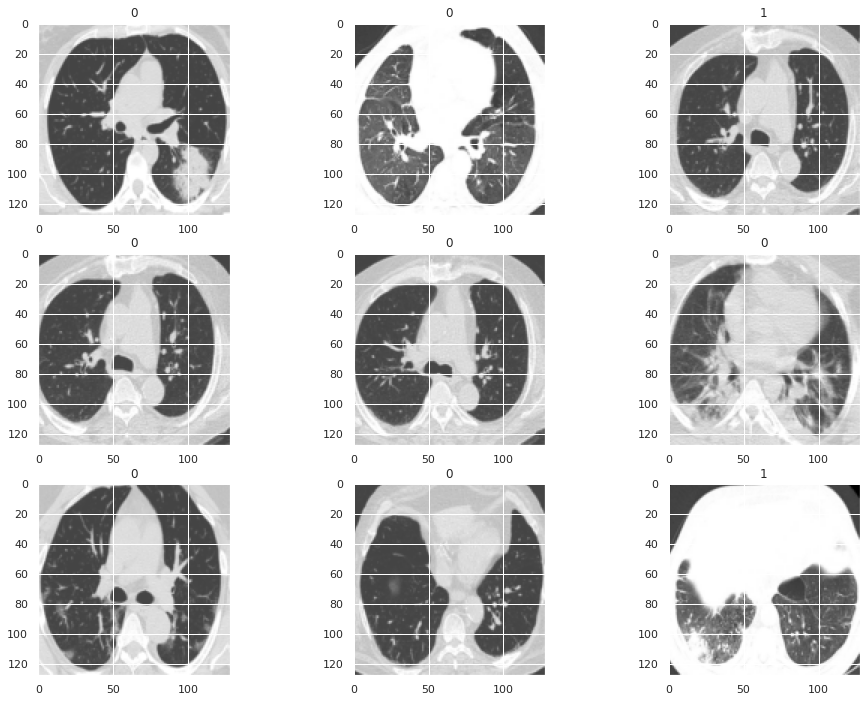

In [223]:
import numpy as np
import matplotlib.pyplot as plt

random_idx = np.random.randint(len(dataset), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
n = 0
for idx, ax in enumerate(axes.ravel()):
    img = transforms.ToPILImage()(dataset[n][0])
    ax.set_title(dataset[random_idx[n]][1])
    ax.imshow(img)
    n +=1

**6-1 Step :**

draw how many photos we have

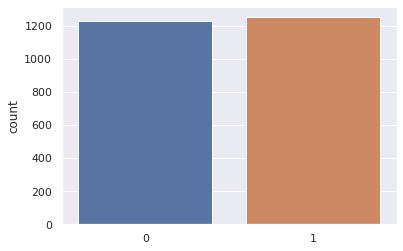

In [224]:
import seaborn as sns
numpyTargets = np.array(dataset.target)
sns.countplot(x=numpyTargets)


**7 Step :**

Split dataset to TrainSet and TestSet

In [225]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

**8 Step :**

Size of each one

In [226]:
print(f"Train Data: {len(train_dataset)}")
print(f"Test Data: {len(test_dataset)}")

Train Data: 1984
Test Data: 497


**9 Step :**

Use Data Loader to load data with batch size 32 for train

In [227]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)

**10 Step :**

Define our Model 

use pretraned resnet18 model with 1 output 

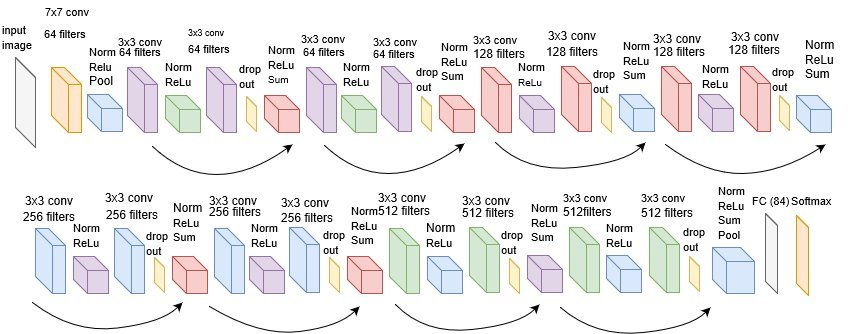

In [228]:
import torch
import torch.nn as nn
from torchvision import models
from torch import Tensor
import torch.optim as optim

class CovidModel(nn.Module):
    def __init__(self, pretrained: bool = True):
        super(CovidModel, self).__init__()
        resnet_model = models.resnet18(pretrained=pretrained)
        resnet_modules = list(resnet_model.children())
        self.model = nn.Sequential(*resnet_modules[:-1]) 
        self.classifier = nn.Linear(resnet_modules[-1].in_features, 1)

    def forward(self, x: Tensor) -> Tensor:
        batch_size = x.size()[0]
        x = self.model(x)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        x = torch.sigmoid(x).squeeze(1)
        return x

**11 Step:**

Set Optimizer and build model

learning rate = 3e-4

optimizer = Adam

In [229]:
model = CovidModel(pretrained=True).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=0)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**12 Step :**

see list of layer

In [230]:
feature_extractor = torch.nn.Sequential(*list(model.children()))

print(feature_extractor)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

**13 Step:**

Reset Parametrs of model befor train

In [231]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

**14 Step:**

Train our the Model in 25 epochs with loss func BCELoss

In [232]:
import numpy as np
# Define the loss
criterion = nn.BCELoss
epochs = 25
train_losses = np.zeros(epochs)
for e in range(epochs):
    train_loss = []
    for inputs, labels in trainloader:    
        labels = labels.to(torch.float32)
        inputs , labels = inputs.to(device) , labels.to(device)
        # Training pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion()(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_losses[e] = train_loss
    print(f'Epoch {e+1}/{epochs} , Train Loss: {train_loss:.4f}')
print('Finished Training')

Epoch 1/25 , Train Loss: 0.2627
Epoch 2/25 , Train Loss: 0.0603
Epoch 3/25 , Train Loss: 0.0446
Epoch 4/25 , Train Loss: 0.0165
Epoch 5/25 , Train Loss: 0.0212
Epoch 6/25 , Train Loss: 0.0393
Epoch 7/25 , Train Loss: 0.0486
Epoch 8/25 , Train Loss: 0.0041
Epoch 9/25 , Train Loss: 0.0171
Epoch 10/25 , Train Loss: 0.0155
Epoch 11/25 , Train Loss: 0.0119
Epoch 12/25 , Train Loss: 0.0043
Epoch 13/25 , Train Loss: 0.0017
Epoch 14/25 , Train Loss: 0.0164
Epoch 15/25 , Train Loss: 0.0175
Epoch 16/25 , Train Loss: 0.0101
Epoch 17/25 , Train Loss: 0.0028
Epoch 18/25 , Train Loss: 0.0005
Epoch 19/25 , Train Loss: 0.0003
Epoch 20/25 , Train Loss: 0.0033
Epoch 21/25 , Train Loss: 0.0114
Epoch 22/25 , Train Loss: 0.0006
Epoch 23/25 , Train Loss: 0.0005
Epoch 24/25 , Train Loss: 0.0050
Epoch 25/25 , Train Loss: 0.0241
Finished Training


**14-1 Step :**

plot Train loss with seaborn library

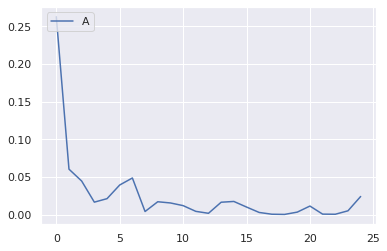

In [233]:
import seaborn as sns
x_lable = list(range(0, 25))

sns.set()
plt.plot(x_lable, train_losses)
plt.legend('ABCDEF', ncol=2, loc='upper left');

**15 Step :**

Check Acc of Model :

In [234]:
def check_accuracy(loader, model):
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    secondlist = []
    lablees = []
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)     
            scores = model(x)
            output = feature_extractor(x)
            secondlist.append(output)
            # print(len(secondlist))
            # print(secondlist)
            predicted = np.where(scores.cpu() > 0.5, 1, 0)
            lablees.append(predicted)
            # print(predicted)
            # print(y)
            num_correct += np.sum(np.equal(predicted, y.cpu().detach().numpy()).astype(float))
            num_samples += len(predicted)        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    model.train()
    return secondlist,lablees

lastLayer,lablees = check_accuracy(testloader,model)


Got 473.0 / 497 with accuracy 95.17


**16 Step :**

Check output model for one of image :

In [235]:
with torch.no_grad():
    tempImage = Image.open("/content/drive/MyDrive/Colab Notebooks/data/non-COVID/Non-Covid (500).png").convert(mode="RGB")
    # print(tempImage)
    tempImage = data_transforms(tempImage)
    # print(tempImage)
    tempImage = tempImage.unsqueeze(0)
    tempImage = tempImage.to(device=device) 
    scores = model(tempImage)
    print(scores)

tensor([0.4745], device='cuda:0')


**16-1 Step :**

find all answer for our data to plot hisogram diagram

In [236]:
with torch.no_grad():
  scores = []
  lable = []
  for i in range(len(dataset)):
    dataset.data[0]
    tempImage = Image.open(dataset.data[i]).convert(mode="RGB")
    lable.append(dataset.target[i])
    tempImage = data_transforms(tempImage)
    tempImage = tempImage.unsqueeze(0)
    tempImage = tempImage.to(device=device) 
    scores.append(model(tempImage))

**16-2 Step :**

Histogram Plot  

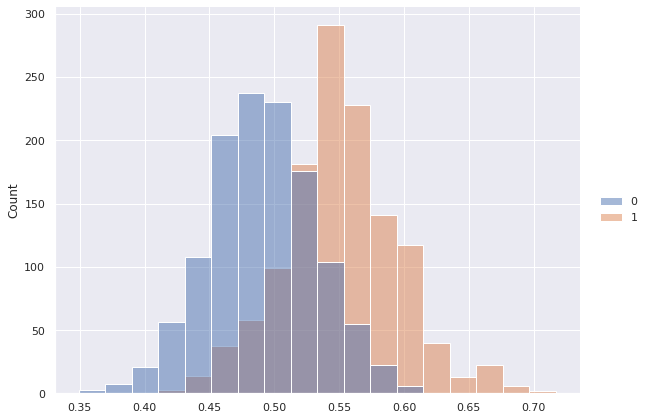

In [237]:
sns.set(style="darkgrid")
scoresCpu = [ a.detach().cpu().numpy() for a in scores]

scoresCpu = np.asarray(scoresCpu)
scoresCpu = scoresCpu.reshape(-1)
# print(scoresCpu.shape)
# lableCpu = [ a.detach().cpu().numpy() for a in lable]

sns.displot(x=scoresCpu, kind="hist",
            height=6, aspect=1.4, bins=18,
            hue=lable)
plt.show()

**17 Step :**

see weight of each layer 

In [238]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[[[-6.0601e-03, -3.2167e-05,  4.5595e-03,  ...,  5.8538e-02,
            1.9509e-02, -1.3149e-02],
          [ 1.6107e-02,  1.3600e-02, -1.0560e-01,  ..., -2.6995e-01,
           -1.3133e-01, -9.9455e-04],
          [-3.2012e-03,  6.1762e-02,  2.9811e-01,  ...,  5.2027e-01,
            2.5476e-01,  5.8859e-02],
          ...,
          [-2.5208e-02,  1.7571e-02,  7.3926e-02,  ..., -3.2901e-01,
           -4.1912e-01, -2.6037e-01],
          [ 3.3922e-02,  4.4141e-02,  6.5950e-02,  ...,  4.1975e-01,
            3.9747e-01,  1.6659e-01],
          [-1.1080e-02,  7.2788e-04, -1.8009e-02,  ..., -1.4586e-01,
           -7.8949e-02, -5.0978e-03]],

         [[-7.0378e-03, -2.0516e-02, -2.8272e-02,  ...,  3.4443e-02,
            3.0881e-03, -2.6199e-02],
          [ 5.0711e-02,  3.7676e-02, -1.0020e-01,  ..., -3.1124e-01,
           -1.6276e-01, -6.0192e-03],
          [ 2.9043e-03,  1.0109e-01,  4.0473e-01,  ...,  7.0844e-01,
            3.6731e-01,  1.1984e-01]

**18 Step :**

use TSNE (t-stochastic neighbor embedding) for test data to Visualizing Data

In [239]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

losses= [ loss.detach().cpu().numpy() for loss in lastLayer]
losses = np.array(losses)
losses = losses.reshape(497,-1)

tsne = TSNE(n_components=2, random_state=42)
mnist_tr = tsne.fit_transform(losses)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


**19 Step :**

Draw TSNE 

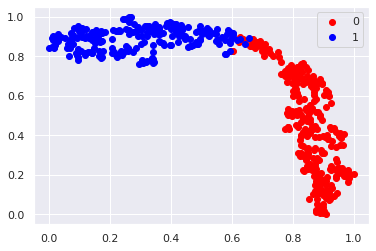

In [240]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = mnist_tr[:, 0]
ty = mnist_tr[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


fig = plt.figure()
ax = fig.add_subplot(111)
colors_per_class = ["red" , "blue"]
for label in range(len(colors_per_class)):
    indices = [i for i, l in enumerate(lablees) if l == label]
    # print(lablees)
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    color =colors_per_class[label]
    ax.scatter(current_tx, current_ty, c=color, label=label)

ax.legend(loc='best')

# finally, show the plot
plt.show()